# TVA sur les biens alimentaires

In [1]:
%matplotlib inline

from __future__ import division

import numpy as np
import os
import pandas as pd
import pkg_resources
import matplotlib.pyplot as plt
import seaborn as sns

from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.build_survey_data.calibration_aliss import get_adjusted_input_data_frame

pd.set_option('precision', 3)

In [2]:
def build_scenarios(reform_key = None):
    year = 2014
    data_year = 2011
    scenario_kwargs = dict(year = year, data_year = data_year, reform_key = reform_key)
    survey_scenario = SurveyScenario.create(**scenario_kwargs)
    #
    adjusted_scenario_kwargs = dict(scenario_kwargs)
    adjusted_scenario_kwargs.update(dict(
        data_year = None,
        input_data_frame = get_adjusted_input_data_frame(reform_key = reform_key[6:])
        ))
    adjusted_survey_scenario = SurveyScenario.create(**adjusted_scenario_kwargs)
    return survey_scenario, adjusted_survey_scenario

In [3]:
def build_pivot_table(variables, by = 'niveau_vie_decile', survey_scenario = None, adjusted_survey_scenario = None):
    pivot_table = pd.DataFrame()
    reference_pivot_table = pd.DataFrame()
    adjusted_pivot_table = pd.DataFrame()
    for variable in variables:
        pivot_table = pd.concat([
            pivot_table,
            survey_scenario.compute_pivot_table(values = [variable], columns = [by])
            ])
        reference_pivot_table = pd.concat([
            reference_pivot_table.fillna(0),
            survey_scenario.compute_pivot_table(values = [variable], columns = [by],
                                               reference = True)
            ])
        adjusted_pivot_table = pd.concat([
            adjusted_pivot_table,
            adjusted_survey_scenario.compute_pivot_table(values = [variable], columns = [by])
            ])
    pivot_table = pd.concat({
        'reform': pivot_table,
        'reference': reference_pivot_table,
        'adjusted': adjusted_pivot_table,
        'reform-reference': pivot_table - reference_pivot_table,
        'adjusted-reform': adjusted_pivot_table - pivot_table,
        'adjusted-reference': adjusted_pivot_table - reference_pivot_table,
        })
    return pivot_table.reset_index().rename(columns = {u'level_0': 'simulation', u'level_1': 'variable'})
     

def build_aggreggates(variables, by = 'niveau_vie_decile', survey_scenario = None, adjusted_survey_scenario = None):
    aggregates = dict()
    reference_aggregates = dict()
    adjusted_aggregates = dict()
    for variable in variables:
        aggregates[variable] = survey_scenario.compute_aggregate(variable) / 1e9
        reference_aggregates[variable] = (
            survey_scenario.compute_aggregate(variable, reference = True) / 1e9
            if np.isfinite(survey_scenario.compute_aggregate(variable, reference = True)) else 0
            )
        
        adjusted_aggregates[variable] = adjusted_survey_scenario.compute_aggregate(variable) / 1e9
    aggregates = pd.DataFrame({
        'reform': aggregates,
        'reference': reference_aggregates,
        'adjusted': adjusted_aggregates,
        })
    aggregates['reform - reference'] = aggregates.reform - aggregates.reference
    aggregates['adjusted - reform'] = aggregates.adjusted - aggregates.reform
    aggregates['adjusted - reference'] = aggregates.adjusted - aggregates.reference
    return aggregates

In [4]:
def run_reform(reform_key = None):
    survey_scenario, adjusted_survey_scenario = build_scenarios(reform_key = reform_key)
    alimentation_domicile_hors_alcool = [
        "depenses_ht_{}".format(key) for key in survey_scenario.tax_benefit_system.column_by_name.keys() \
        if key.startswith(u'poste_01')
        ]
    alimentation_domicile = alimentation_domicile_hors_alcool + [
        'depenses_biere',
        'depenses_vin',
        'depenses_alcools_forts'
        ]
    depenses_ht_tvas = [
        "depenses_ht_{}".format(key) for key in survey_scenario.tax_benefit_system.column_by_name.keys() \
        if key.startswith(u'tva_taux_')
        ]
    tvas = [
        key for key in survey_scenario.tax_benefit_system.column_by_name.keys() \
        if key.startswith(u'tva_taux_')
        ] + ['tva_total']
    variables = alimentation_domicile + ['poste_agrege_01', 'poste_agrege_02', ] + depenses_ht_tvas + tvas
    aggregates = build_aggreggates(variables, survey_scenario = survey_scenario, adjusted_survey_scenario = adjusted_survey_scenario)
    pivot_table = build_pivot_table(variables, survey_scenario = survey_scenario, adjusted_survey_scenario = adjusted_survey_scenario)
    
    # Some tests
    assert (pd.DataFrame(
    aggregates.loc[aliment, 'reform'] - aggregates.loc[aliment, 'reform'] for aliment in alimentation_domicile
    ) == 0).all().all()
    
    assert aggregates.loc['poste_agrege_02', 'reform'] - aggregates.loc['poste_agrege_02', 'reference'] < 1e-7
    
    return aggregates, pivot_table

('kantar_expenditures_total:', 51.138801663999999)
('bdf_expenditures_total: ', 51.317714944000002)
('population_kantar_total: ', 11960.85774230957)
('bdf_expenditures_total: ', 126.62905879583185)


/home/benjello/openfisca/openfisca-france-indirect-taxation/openfisca_france_indirect_taxation/build_survey_data/calibration_aliss.py:125: FutureWarning: eval expressions containing an assignment currentlydefault to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  input_data_frame.eval("age = 0 + (agepr > 30) + (agepr > 45) + (agepr > 60)",
/home/benjello/openfisca/openfisca-survey-manager/openfisca_survey_manager/statshelpers.py:122: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  ret[and_(data >= lower, data < upper)] = labels[i]


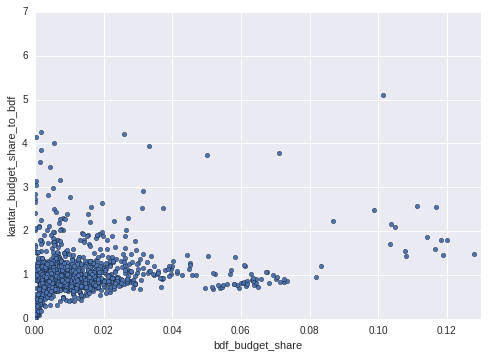

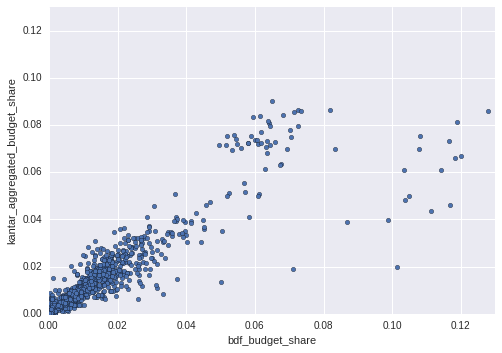

In [5]:
data_by_reform_key = dict()
for reform_key in ['aliss_environnement']: #, 'aliss_tva_sociale', 'aliss_mixte', 'aliss_sante']:
    aggregates, pivot_table = run_reform(reform_key = reform_key)
    data_by_reform_key[reform_key] = dict(aggregates = aggregates, pivot_table = pivot_table)


In [6]:
reform_key = 'aliss_environnement'
aggregates = data_by_reform_key[reform_key]['aggregates']
aggregates.loc[
    [index for index in aggregates.index if index.startswith('tva_') or index.startswith('poste_agrege')]
    ]

,adjusted,reference,reform,reform - reference,adjusted - reform,adjusted - reference
poste_agrege_01,122.469,124.140,125.804,1.664e+00,-3.335,-1.671
poste_agrege_02,21.892,22.431,22.431,2.735e-08,-0.539,-0.539
tva_taux_01_1_2_4_2,0.774,0.000,0.810,8.103e-01,-0.037,0.774
tva_taux_01_1_2_6_3,0.194,0.000,0.201,2.005e-01,-0.006,0.194
tva_taux_01_1_3_2_2,0.195,0.000,0.203,2.032e-01,-0.008,0.195
tva_taux_intermediaire,8.905,7.559,9.119,1.560e+00,-0.214,1.345
tva_taux_plein,62.474,63.155,63.845,6.905e-01,-1.371,-0.681
tva_taux_reduit,5.163,7.069,5.269,-1.800e+00,-0.106,-1.906
tva_taux_super_reduit,0.139,0.141,0.141,0.000e+00,-0.002,-0.002
tva_total,76.680,77.924,78.374,4.502e-01,-1.694,-1.244


In [7]:
aggregates

,adjusted,reference,reform,reform - reference,adjusted - reform,adjusted - reference
depenses_alcools_forts,2.833,2.932,2.932,0.000e+00,-0.099,-0.099
depenses_biere,1.188,1.301,1.301,0.000e+00,-0.114,-0.114
depenses_ht_poste_01_10_1,2.868,2.924,2.924,0.000e+00,-0.056,-0.056
depenses_ht_poste_01_10_2,1.401,1.427,1.427,0.000e+00,-0.025,-0.025
depenses_ht_poste_01_1_1_1_1,13.052,13.376,13.376,0.000e+00,-0.324,-0.324
depenses_ht_poste_01_1_1_3_3,3.606,3.730,3.730,0.000e+00,-0.124,-0.124
depenses_ht_poste_01_1_1_4_1,1.449,1.488,1.488,0.000e+00,-0.038,-0.038
depenses_ht_poste_01_1_1_4_2,1.561,1.615,1.615,0.000e+00,-0.054,-0.054
depenses_ht_poste_01_1_1_4_3,0.754,0.851,0.851,0.000e+00,-0.097,-0.097
depenses_ht_poste_01_1_2_1_1,7.208,7.457,7.457,0.000e+00,-0.249,-0.249


In [8]:
aggregates = data_by_reform_key[reform_key]['pivot_table']
variables = [variable for variable in pivot_table.variable.unique() if variable.startswith('poste_agrege')]
data = pivot_table.query('variable in @variables')
data = pivot_table.set_index(['simulation', 'variable']).sort_index()
data.head()

niveau_vie_decile                             1        2        3        4   \
simulation variable                                                           
adjusted   depenses_alcools_forts         53.946   68.281  105.565   89.912   
           depenses_biere                 28.122   28.014   34.351   47.109   
           depenses_ht_poste_01_10_1      61.937   49.502   63.844   84.465   
           depenses_ht_poste_01_10_2      32.135   27.995   28.364   24.543   
           depenses_ht_poste_01_1_1_1_1  350.387  387.986  415.293  443.854   

niveau_vie_decile                             5        6        7        8   \
simulation variable                                                           
adjusted   depenses_alcools_forts        100.090  109.239  114.502  126.817   
           depenses_biere                 40.349   43.868   42.532   48.902   
           depenses_ht_poste_01_10_1      86.078   95.727  127.778  132.625   
           depenses_ht_poste_01_10_2      48.703   47.221   48.184   50.849   
           depenses_ht_poste_01_1_1_1_1  457.869  485.078  505.317  527.854   

niveau_vie_decile                             9        10  
simulation variable                                        
adjusted   depenses_alcools_forts        123.998  127.505  
           depenses_biere                 55.633   58.613  
           depenses_ht_poste_01_10_1     160.632  169.749  
           depenses_ht_poste_01_10_2      77.300  119.100  
           depenses_ht_poste_01_1_1_1_1  544.870  579.619

In [9]:
df = data.loc(axis=0)[(['adjusted-reference', 'reform-reference'], ['poste_agrege_01', 'tva_total'])]
df

niveau_vie_decile                       1       2       3        4       5   \
simulation         variable                                                   
adjusted-reference poste_agrege_01  -1.207  26.792  49.465  105.103  51.296   
                   tva_total        44.662  26.374  23.203    6.040  14.636   
reform-reference   poste_agrege_01  38.859  42.546  44.294   48.978  57.699   
                   tva_total        11.978  12.099   7.650   10.558  13.293   

niveau_vie_decile                       6       7       8       9       10  
simulation         variable                                                 
adjusted-reference poste_agrege_01  45.746  43.182  95.451  49.820  83.896  
                   tva_total        25.449  37.632  33.173  26.862  36.533  
reform-reference   poste_agrege_01  62.180  57.228  68.955  75.829  87.059  
                   tva_total        18.070  10.354  20.974  23.266  29.642

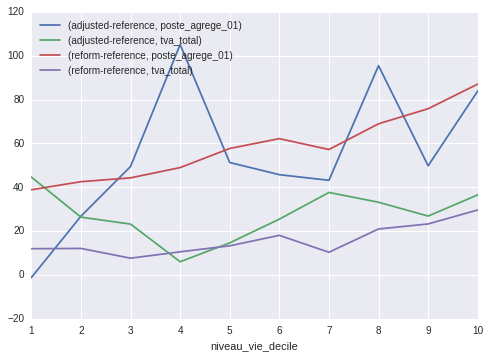

In [10]:
df.T.plot()
plt.legend(loc='upper left')
sns.despine()

In [11]:
import qgrid
qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to your /nbextensions folder
qgrid.show_grid(pivot_table)